In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 744 kB/s            
     |████████████████████████████████| 8.2 MB 1.7 MB/s            


In [10]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
import pymorphy2
import re

import tensorflow as tf

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Михаил\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Михаил\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
test = pd.read_parquet('data/test.parquet')
train = pd.read_parquet('data/train.parquet')
tree = pd.read_csv('data/categories_tree.csv')

In [13]:
print('Train:', train.shape)
print('Test: ', test.shape)

Train: (283452, 7)
Test:  (70864, 6)


In [14]:
train.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


## Data preprocessing

Для предобработки буду использовать токенизацию из nltk.tokenize, затем отбрасывать все, кроме букв, проверять на русские стоп слова и лемматизировать с помощью pymorphy2

In [15]:
def preprocessing(x):
    text = x
    if text != None:
        tock_dirt = word_tokenize(text, language="russian")
        morph_lst = []
        tock = []
        for word in tock_dirt:
            word = re.sub("[^A-Za-zА-Яа-я]", " ", word)
            for i in word.split():
                if i != []:
                    if i not in stopwords.words("russian"):
                        morph_lst.append(morph.parse(i)[0].normal_form)
        return morph_lst
    else:
        return []

In [16]:
train_copy = train.copy()

col_title = train_copy.title.apply(preprocessing)

col_short_description = train_copy.short_description.apply(preprocessing)

col_list = (col_title + col_short_description)

col_list = col_list.apply(lambda x: list(dict.fromkeys(x)))

df_arr = col_list.to_numpy()

In [9]:
#col_list.to_csv('data/col_list.csv')

In [9]:
# Для загрузки уже токенизированных фичей
# from ast import literal_eval
# col_list = pd.read_csv('data/col_list.csv', index_col='Unnamed: 0', squeeze=True, converters={'lists':literal_eval})
# col_list = col_list.apply(eval)
# col_list = col_list.apply(lambda x: list(dict.fromkeys(x)))
# df_arr = col_list.to_numpy()

In [17]:
# Приведем наши метки классов к типу category и закодируем с помощью one_hot

train["category_id"] = train["category_id"].astype('category')
d_cat_id = dict(enumerate(train["category_id"].cat.categories))
train["cat"] = train["category_id"].cat.codes
train_labels = tf.one_hot(train["cat"], train["cat"].unique().shape[0])

In [12]:
# Обучим word2vec на наших токенизированных фичах

from gensim.models import word2vec

#config
vector_size = 300

w2v_model = word2vec.Word2Vec(
    df_arr,
    vector_size=vector_size, 
    window=2,
    min_count=1,
    sg=1 
)

In [13]:
vocab_list = list(w2v_model.wv.key_to_index.keys())
len(vocab_list)

51050

Я буду использовать Keras со слоем Embedding. Чтобы использовать word2vec в этом слое нам нужны веса, организованные в матрицу размером vocab_size x embedding_size. Это не что иное, как матрица, где вектор в i-й строке является вектором i-го слова в словаре модели word2vec.

In [14]:
# Получим embedding matrix

vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]
embedding_matrix.shape

(51050, 300)

Для дальнейшей работы нужно стандартизировать размер входного слоя, т.е. определить длину последовательностей и ограничить их.

Поэтому я проанализировал длину "предложений" в выборке, построив гистограмму количества слов в каждой последовательностей. В среднем большинство образцов содержат около 6-7 слов. Чтобы захватить чуть больше среднего количества слов, я выбрал 10.

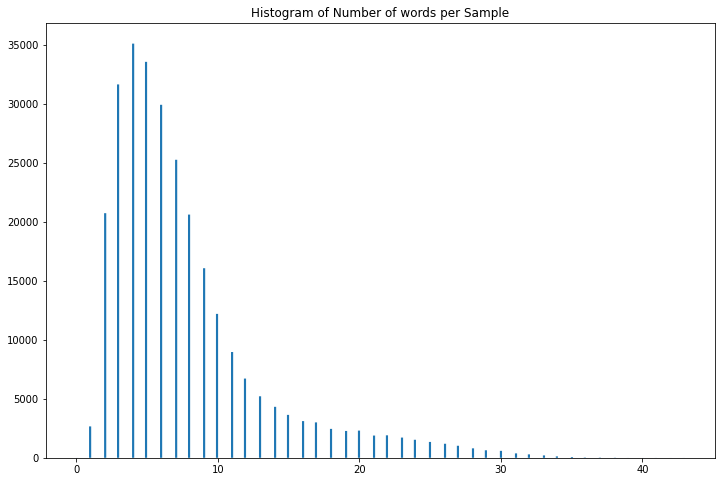

In [15]:
plt.figure(figsize=(12,8))
plt.hist(np.apply_along_axis(lambda x: len(x[0]), axis=0, arr=[df_arr]), bins='auto', histtype='stepfilled')
plt.title("Histogram of Number of words per Sample")
plt.show()

Теперь подготовим данные для обучения: заменим токены индексом слова в словаре word2vec. Во время обучения классификатора, вектор слова будет выбран путем сопоставления индекса токена с номером строки в embedding matrix

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
max_seq_len = 10

def w2v_indexed_token_sequences(w2v_model, list_features):
    indexed_features = []
    for each_seq in list_features:
        list_token_indices = []
        for each_token in each_seq:
            try:
                list_token_indices.append(w2v_model.wv.key_to_index[each_token])
            except KeyError as e:
                continue
        indexed_features.append(list_token_indices)
    return indexed_features

In [18]:
indexed_train_features = w2v_indexed_token_sequences(w2v_model, df_arr)

padded_train = pad_sequences(indexed_train_features, padding = 'post', maxlen=max_seq_len, truncating='post')

## Fit model

Слой Embedding из Keras инициализирует матрицу со входным измерением — размером словаря, и выходным измерением — размером репрезентативного вектора, используется для того чтобы составить таблицу всех вхождений слов всего словаря. Для каждого входящего числа — токена в словаре, будет сопоставляться строка из embedding matrix.

В конце я использовал полностью связанный слой размерностью 1231 (1231 класса для прогнозирования) с активацией «softmax». Label с наибольшим значением будет считаться как наиболее вероятное значение класса. Обучение в течение 10 эпох с возможностью досрочного завершения

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM

In [20]:
def get_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=vector_size,
                  weights=[embedding_matrix],
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(max_seq_len,return_sequences=True))
    model.add(2 слоя (1231))
    model.add(Dense(1231,activation='softmax'))
    return model
 
# зададим условие досрочной остановки и сохранения лучшей модели
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=1,
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_w2v.hdf5',
                                    verbose=1,
                                    save_best_only=True)
]

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
model = get_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
tf.config.run_functions_eagerly(True)

# Сохраним историю лоссов
history = model.fit(padded_train, 
                    train_labels,
                    validation_split=0.33,
                    callbacks=callbacks,
                    epochs=10)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2022-04-23 21:03:59.484459: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 935126688 exceeds 10% of free system memory.
2022-04-23 21:04:00.169004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-23 21:04:00.933711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5935/5935 [==============================] - 214s 36ms/step - loss: 1.9378 - accuracy: 0.5635 - val_loss: 1.0236 - val_accuracy: 0.7412

Epoch 00001: val_loss improved from inf to 1.02360, saving model to models/lstm_with_w2v.hdf5
Epoch 2/10
4408/5935 [=====================>........] - ETA: 44s - loss: 0.9600 - accuracy: 0.7489

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5935/5935 [==============================] - 210s 35ms/step - loss: 0.9399 - accuracy: 0.7538 - val_loss: 0.8155 - val_accuracy: 0.7891

Epoch 00002: val_loss improved from 1.02360 to 0.81552, saving model to models/lstm_with_w2v.hdf5
Epoch 3/10
5935/5935 [==============================] - 213s 36ms/step - loss: 0.7294 - accuracy: 0.8024 - val_loss: 0.7358 - val_accuracy: 0.8117

Epoch 00003: val_loss improved from 0.81552 to 0.73575, saving model to models/lstm_with_w2v.hdf5
Epoch 4/10
2237/5935 [==========>...................] - ETA: 1:45 - loss: 0.6133 - accuracy: 0.8278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5935/5935 [==============================] - 211s 36ms/step - loss: 0.6127 - accuracy: 0.8287 - val_loss: 0.6991 - val_accuracy: 0.8206

Epoch 00004: val_loss improved from 0.73575 to 0.69908, saving model to models/lstm_with_w2v.hdf5
Epoch 5/10
5610/5935 [===========================>..] - ETA: 9s - loss: 0.5345 - accuracy: 0.8468

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5935/5935 [==============================] - 208s 35ms/step - loss: 0.5344 - accuracy: 0.8467 - val_loss: 0.6995 - val_accuracy: 0.8241

Epoch 00005: val_loss did not improve from 0.69908
Epoch 6/10
5935/5935 [==============================] - 210s 35ms/step - loss: 0.4747 - accuracy: 0.8602 - val_loss: 0.6914 - val_accuracy: 0.8279

Epoch 00006: val_loss improved from 0.69908 to 0.69141, saving model to models/lstm_with_w2v.hdf5
Epoch 7/10
2318/5935 [==========>...................] - ETA: 1:43 - loss: 0.4147 - accuracy: 0.8736

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



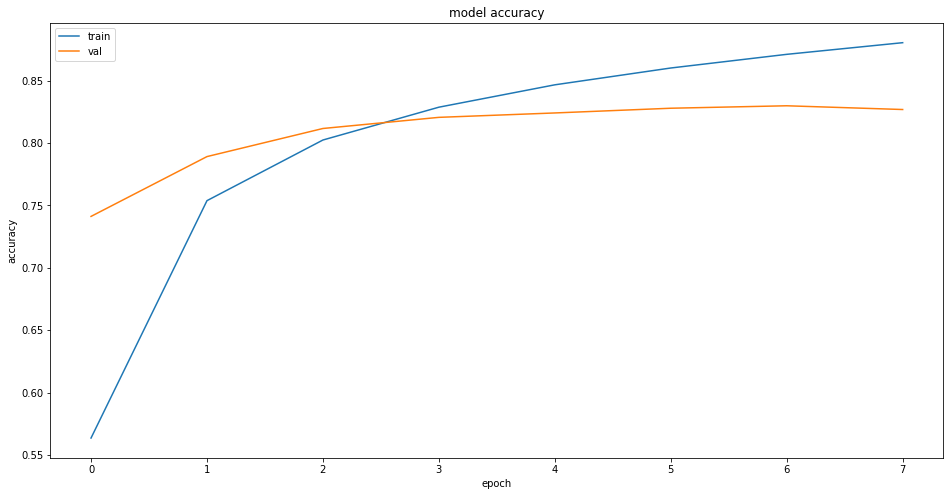

In [23]:
plt.figure(figsize=(16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

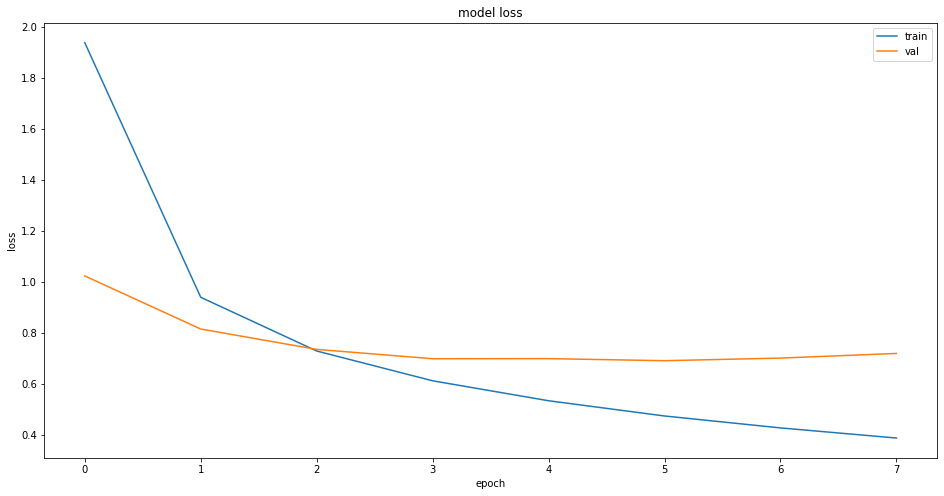

In [24]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [25]:
# Загрузим сохраненную модель

model_with_w2v = keras.models.load_model('/models/lstm_with_w2v.hdf5')

In [42]:
# Предсказание
y_pred_one_hot_encoded = (model_with_w2v.predict(padded_train)> 0.5).astype("int32")

# Декодирование предсказания из one-hot вида
y_pred_train = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2022-04-23 21:59:24.928203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1395717648 exceeds 10% of free system memory.
2022-04-23 21:59:41.553434: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1395717648 exceeds 10% of free system memory.


In [54]:
from sklearn.metrics import classification_report

report = classification_report(train['cat'], y_pred_train, output_dict=True)

print('accuracy:        ', round(report['accuracy'], 6))
print('F1 macro_avg:    ', list(report['macro avg'].values())[2])
print('F1 weighted_avg: ', list(report['weighted avg'].values())[2])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:         0.851767
F1 macro_avg:     0.706793599879776
F1 weighted_avg:  0.8673095641562565


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## hF1

In [55]:
d = dict()
for k in train.category_id.unique():
    d[k] = []

In [56]:
for item_id in train.category_id.unique():
    next_id = item_id
    d[item_id].append(next_id)
    while next_id != 1:
        next_id = int(tree[tree.id == next_id].parent_id.values)
        d[item_id].append(next_id)
    d[item_id].append(0)

In [66]:
def hF1(true_label, pred_label, d):
    nominator_sum = 0
    totalPh = 0
    totalTh = 0
    
    for t_label, p_label in zip(true_label, pred_label):
        Ph = set(d[p_label])
        Th = set(d[t_label])

        nominator_sum += len(Ph & Th)
        totalPh += len(Ph)
        totalTh += len(Th)
    
    hP = nominator_sum / totalPh
    hR = nominator_sum / totalTh
    hF = (2 * hP * hR) / (hP + hR)
    print("hP:  " + str(hP))
    print("hR:  " + str(hR))
    print("hF1: " + str(hF))

In [67]:
y_pred = pd.DataFrame(y_pred_train, columns=['pred']).pred.map(d_cat_id).to_list()
y_true = train.category_id.to_list()

In [68]:
hF1(y_true, y_pred, d)

hP:  0.929293503462925
hR:  0.9313783107270976
hF1: 0.930334739124041


## Preprocessing Test data

In [69]:
#Токенизируем

test_copy = test.copy()

col_title = test_copy.title.apply(preprocessing)

col_short_description = test_copy.short_description.apply(preprocessing)

col_list = (col_title + col_short_description)

col_list = col_list.apply(lambda x: list(dict.fromkeys(x)))

In [70]:
test_arr = col_list.to_numpy()

При обучении word2vec самостоятельно на относительно небольшой выборке, возникает проблема различия словарей тренировочной и тестовой части данных, т.к. каждое слово хранится с использованием ключа, который однозначно идентифицирует его. 

Используем метод Out of Vocab (OOV) - сравним и отбросим слова из тестовых данных, используя словарь, используемый для обучения модели Word2Vec.

In [71]:
vocab_list = list(w2v_model.wv.key_to_index.keys())

def remove_OOV_vocab(sample: list, list_vocab):
    in_vocab_sample = []
    for each_token in sample:
        if each_token in list_vocab:
            in_vocab_sample.append(each_token)
    return in_vocab_sample
  
test_arr = [remove_OOV_vocab(each_test_sample, vocab_list) for each_test_sample in test_arr]

In [72]:
indexed_test_features = w2v_indexed_token_sequences(w2v_model, test_arr)

padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')

## Predict

In [73]:
y_pred_one_hot_encoded = (model_with_w2v.predict(padded_test)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [74]:
y_pred_test.shape

(70864,)

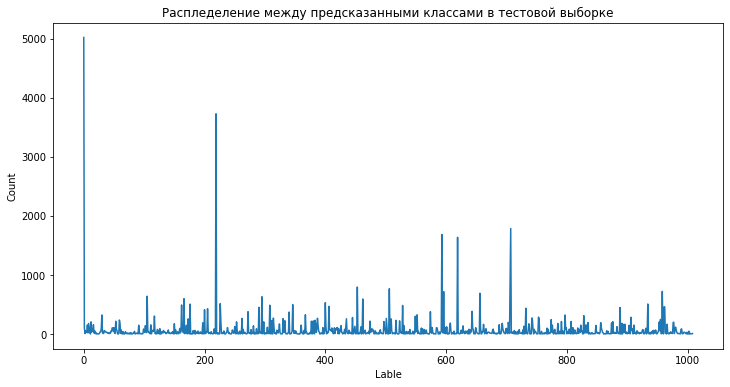

In [75]:
plt.figure(figsize=(12,6))
plt.plot(np.unique(y_pred_test, return_counts=True)[1])
plt.title('Распределение между предсказанными классами в тестовой выборке')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

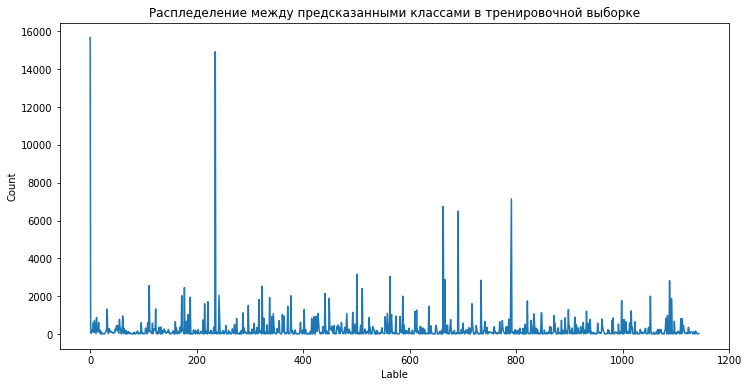

In [76]:
plt.figure(figsize=(12,6))
plt.plot(np.unique(y_pred_train, return_counts=True)[1])
plt.title('Распределение между предсказанными классами в тренировочной выборке')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

In [22]:
y_pred = pd.DataFrame(y_pred_test, columns=['pred']).pred.map(d_cat_id).to_list()

In [24]:
# Сохранение решения

submission = pd.DataFrame()
submission['id'] = test.id
submission['predicted_category_id'] = y_pred
submission.to_parquet('./result.parquet', index=False)